In [6]:
%load_ext autoreload
%autoreload complete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from protest_impact.util import cache, project_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = pd.read_csv(project_root / "data/daily_data.csv")
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

In [8]:
from protest_impact.synthetic_region.data import get_data_parts

old_metadata_list = get_data_parts(["all"], 0.01)
print(old_metadata_list[0].keys())
old_metadata_list[0].df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


dict_keys(['start_date', 'end_date', 'protest_groups', 'source', 'discourse_type', 'prediction_interval', 'n_days_protest_free_pre', 'n_days_protest_free_post', 'aggregate_protests', 'event_date', 'sub_event_type', 'assoc_actor_1', 'admin1', 'location', 'notes', 'weekday', 'region_code', 'size', 'n_protests', 'largest_protest_size', 'has_mixed_groups', 'df'])


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


region,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Thüringen
-374,14,7,2,1,4,4,3,0,0,0
-373,20,7,7,2,3,3,2,3,1,0
-372,22,14,4,0,6,3,1,5,2,0
-371,20,9,1,0,4,4,3,9,1,0
-370,7,8,4,1,3,1,0,3,0,0


In [9]:
from munch import Munch

config = Munch(
    # method="lasso",
    # interpretable=True,
    # alpha=0.1,
    # use_autoregressor=False,
    method="sociodemographic",
    sociodemographic__method="nmf",
    sociodemographic__sum_to_one=True,
    ignore_neighbor_regions=True,
    agg_weekly=False,
    normalize="standard",
    training_interval=28 * 3,
    prediction_interval=14,
)

In [10]:
_df = df.query("date >= '2020-04-01' and date < '2022-10-01'")
print(_df.shape)
print(_df[(_df["size_moderate"] > 0) | (_df["size_radical"] > 0)]["date"].shape)
print(
    _df[(_df["size_moderate_official"] > 0) | (_df["size_radical_official"] > 0)][
        "date"
    ].shape
)
print(
    _df[
        (_df["size_moderate"] > 0)
        | (_df["size_radical"] > 0)
        | (_df["size_moderate_official"] > 0)
        | (_df["size_radical_official"] > 0)
    ]["date"].shape
)

(12782, 28)
(211,)
(214,)
(387,)


In [11]:
from munch import Munch

from protest_impact.synthetic_region.hyperopt import objective


def get_protests(df):
    df = df.query("date >= '2020-04-01' and date < '2022-12-01'")
    return df[(df["size_moderate"] > 0) | (df["size_radical"] > 0)].to_dict(
        orient="records"
    )


def get_region_ts(
    df,
    date,
    region,
    discourse_type,
    free_during,
    free_before,
    free_after,
    exclusion_method,
):
    assert exclusion_method in [
        "exclude_none",
        "exclude_acled",
        "exclude_official",
        "exclude_all",
        "exclude_regions",
    ]
    region_df = df[df["region"] == region]
    ts = region_df[region_df["date"] >= date - pd.Timedelta(days=3 * 28)]
    ts = ts[ts["date"] < date + pd.Timedelta(days=free_after)]
    ts.name = region
    ts = ts.reset_index(drop=True)
    # set index such that the protest data has index 0
    ts.index = np.arange(-3 * 28, free_after)
    protest_counts = pd.Series(0, index=ts.index)
    if exclusion_method in ["exclude_acled", "exclude_all"]:
        protest_counts += ts["count_radical"] + ts["count_moderate"]
    if exclusion_method in ["exclude_official", "exclude_all"]:
        # this excludes:
        # a) regions with protests in the official dataset
        # b) regions that are not represented in the official dataset
        protest_counts += (
            ts["count_radical_official"] + ts["count_moderate_official"]
        ).fillna(1)
    if exclusion_method == "exclude_regions":
        # this just excludes regions that are not represented in the official dataset
        official_counts = ts["count_radical_official"] + ts["count_moderate_official"]
        protest_counts = official_counts.apply(lambda x: 1 if np.isnan(x) else 0)
    if protest_counts.loc[-free_before:-1].sum() > 0:
        return None
    if protest_counts.loc[1:free_after].sum() > 0:
        return None
    if free_during and protest_counts.loc[0] > 0:
        return None
    return ts[discourse_type].rename(region)


def get_protest_ts(
    df, date, region, discourse_type, exclusion_method, free_before=6, free_after=None
):
    ts = get_region_ts(
        df,
        date,
        region,
        discourse_type,
        False,
        free_before,
        free_after,
        exclusion_method="exclude_all",
    )
    if ts is None:
        return None
    for _region in df["region"].unique():
        if _region == region:
            continue
        _ts = get_region_ts(
            df,
            date,
            _region,
            discourse_type,
            True,
            free_before,
            free_after,
            exclusion_method,
        )
        if _ts is None:
            continue
        ts = pd.concat([ts, _ts], axis=1)
    if isinstance(ts, pd.Series) or ts.shape[1] <= 1:
        return None
    return ts


def get_impacts(exclusion_method, discourse_type="climate_and_protest_mediacloud"):
    results = []
    for region in df["region"].unique():
        region_df = df[df["region"] == region]
        protests = get_protests(region_df)
        for protest in protests:
            ts = get_protest_ts(
                df,
                protest["date"],
                region,
                discourse_type,
                exclusion_method,
                free_after=config.prediction_interval,
            )
            _config = Munch(
                **config,
                df=ts,
                source="mediacloud",
                admin1=region,
                date=protest["date"],
                size_moderate=protest["size_moderate"],
                size_radical=protest["size_radical"],
                size_moderate_official=protest["size_moderate_official"],
                size_radical_official=protest["size_radical_official"],
            )
            if ts is None:
                continue
            result = objective(_config)
            if result.pruned:
                continue
            results.append(result)
    results = pd.DataFrame(results)
    return results

In [12]:
def visualize_daily(results, label=None):
    impacts = [
        [r[f"impact_day_{i}"] for i in range(config.prediction_interval)]
        for r in results.to_dict("records")
    ]
    plt.plot(np.median(impacts, axis=0), label=label)
    plt.fill_between(
        np.arange(config.prediction_interval),
        np.quantile(impacts, 0.25, axis=0),
        np.quantile(impacts, 0.75, axis=0),
        alpha=0.2,
    )


def visualize_cumulative(results, label=None):
    cumulative_impacts = [
        np.cumsum([r[f"impact_day_{i}"] for i in range(config.prediction_interval)])
        for r in results.to_dict("records")
    ]
    plt.plot(np.median(cumulative_impacts, axis=0), label=label)
    # plt.fill_between(
    #     np.arange(config.prediction_interval),
    #     np.quantile(cumulative_impacts, 0.25, axis=0),
    #     np.quantile(cumulative_impacts, 0.75, axis=0),
    #     alpha=0.2,
    # )
    plt.plot(
        np.arange(config.prediction_interval),
        np.quantile(cumulative_impacts, 0.25, axis=0),
        alpha=0.5,
        linestyle="--",
        linewidth=0.5,
    )
    plt.plot(
        np.arange(config.prediction_interval),
        np.quantile(cumulative_impacts, 0.75, axis=0),
        alpha=0.5,
        linestyle="--",
        linewidth=0.5,
    )


def visualize(results):
    visualize_daily(results)
    visualize_cumulative(results)
    plt.axhline(0, color="black", linestyle="--")
    plt.show()

(81, 36)


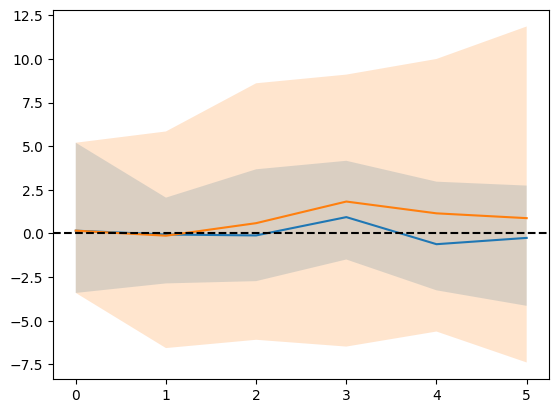

In [13]:
results = get_impacts("exclude_none")
print(results.shape)
visualize(results)

(67, 36)


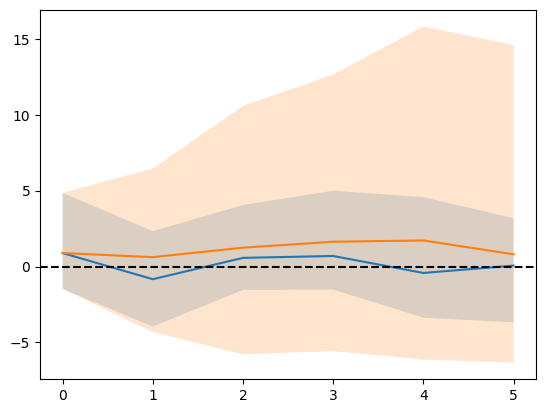

In [14]:
results = get_impacts("exclude_acled")
print(results.shape)
visualize(results)

(78, 36)


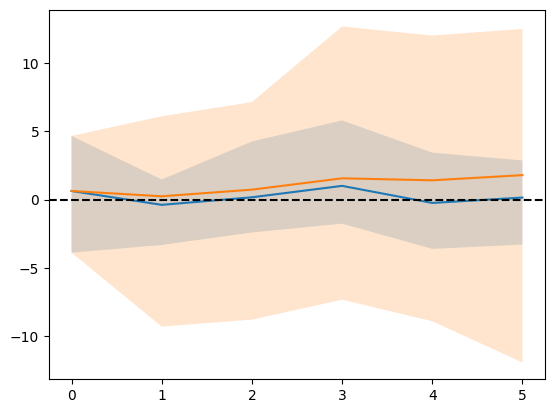

In [15]:
results = get_impacts("exclude_official")
print(results.shape)
visualize(results)

(55, 36)


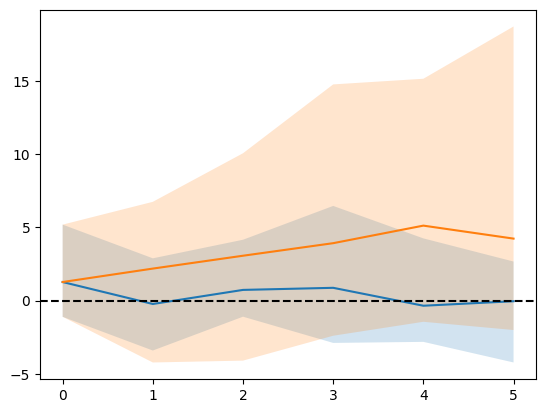

In [16]:
results = get_impacts("exclude_all")
print(results.shape)
visualize(results)

(81, 36)


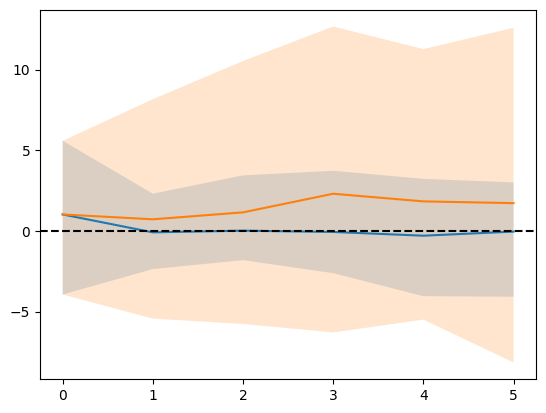

In [17]:
results = get_impacts("exclude_regions")
print(results.shape)
visualize(results)

In [18]:
results_exclude_none = get_impacts("exclude_none")
results_exclude_acled = get_impacts("exclude_acled")
results_exclude_official = get_impacts("exclude_official")
results_exclude_all = get_impacts("exclude_all")

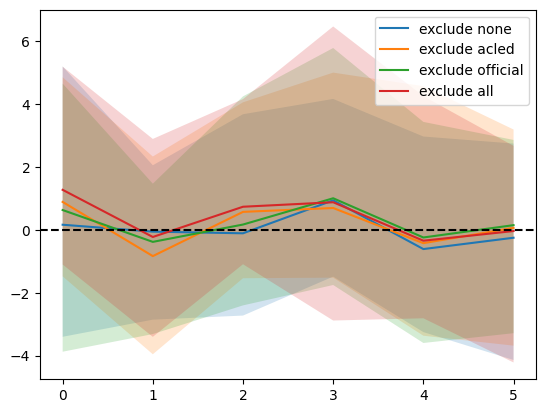

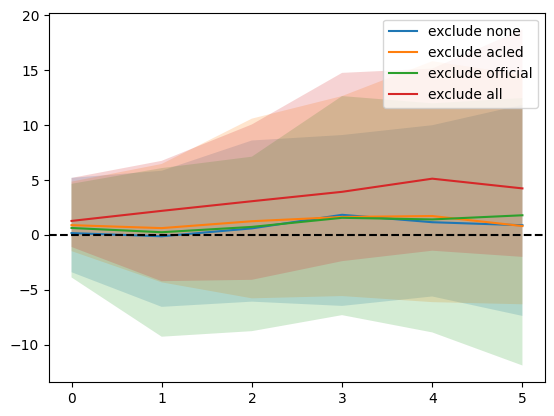

In [19]:
visualize_daily(results_exclude_none, label="exclude none")
visualize_daily(results_exclude_acled, label="exclude acled")
visualize_daily(results_exclude_official, label="exclude official")
visualize_daily(results_exclude_all, label="exclude all")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.show()

visualize_cumulative(results_exclude_none, label="exclude none")
visualize_cumulative(results_exclude_acled, label="exclude acled")
visualize_cumulative(results_exclude_official, label="exclude official")
visualize_cumulative(results_exclude_all, label="exclude all")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.show()

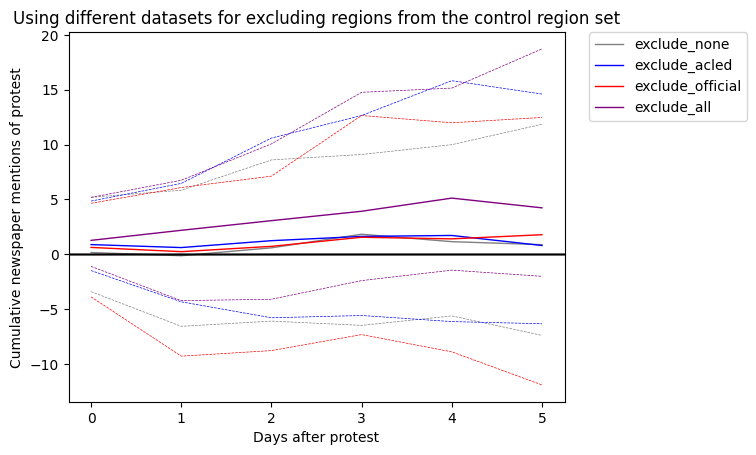

In [28]:
labels = ["exclude_none", "exclude_acled", "exclude_official", "exclude_all"]
color = ["grey", "blue", "red", "purple"]

for label, color in zip(labels, color):
    results = get_impacts(label)
    cumulative_impacts = [
        np.cumsum([r[f"impact_day_{i}"] for i in range(config.prediction_interval)])
        for r in results.to_dict("records")
    ]
    plt.plot(
        np.median(cumulative_impacts, axis=0), label=label, color=color, linewidth=1
    )
    # plt.fill_between(
    #     np.arange(config.prediction_interval),
    #     np.quantile(cumulative_impacts, 0.25, axis=0),
    #     np.quantile(cumulative_impacts, 0.75, axis=0),
    #     alpha=0.2,
    # )
    plt.plot(
        np.arange(config.prediction_interval),
        np.quantile(cumulative_impacts, 0.25, axis=0),
        # alpha=0.5,
        linestyle="--",
        linewidth=0.5,
        color=color,
    )
    plt.plot(
        np.arange(config.prediction_interval),
        np.quantile(cumulative_impacts, 0.75, axis=0),
        # alpha=0.5,
        linestyle="--",
        linewidth=0.5,
        color=color,
    )
plt.axhline(0, color="black", linestyle="-", linewidth=1)
# legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.xlabel("Days after protest")
plt.ylabel("Cumulative newspaper mentions of protest")
plt.title("Using different datasets for excluding regions from the control region set")
plt.show()

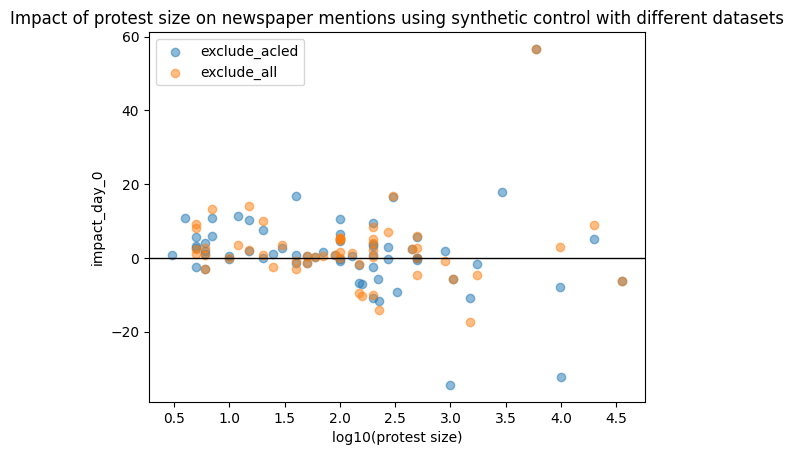

In [36]:
for m in ["exclude_acled", "exclude_all"]:
    results = get_impacts(m)
    results["size"] = results["size_moderate"] + results["size_radical"]
    plt.scatter(np.log10(results["size"]), results["impact_day_0"], label=m, alpha=0.5)
plt.legend()
plt.xlabel("log10(protest size)")
plt.ylabel("impact_day_0")
plt.title(
    "Impact of protest size on newspaper mentions using synthetic control with different datasets"
)
plt.axhline(0, color="black", linestyle="-", linewidth=1)
plt.show()